In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np

import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Conv2D, Dense, ReLU, BatchNormalization, Input, Flatten, Concatenate, Reshape, UpSampling2D,\
Activation, Conv2DTranspose, LeakyReLU, Dropout
from keras import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.metrics import Mean

from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from keras.losses import BinaryCrossentropy

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load MNIST digits data set

In [8]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1)
# x_test = np.expand_dims(x_test, axis=-1)

In [9]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype=np.float32)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype=np.float32)

In [10]:
x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 10))

In [11]:
def mnist_transform(x):
    return (tf.cast(x, tf.float32) / 127.5) - 1.0

In [12]:
np.random.choice([1, 4, 5], 3)

array([5, 5, 4])

In [13]:
np.random.choice(np.arange(10), 10)

array([8, 4, 9, 0, 7, 7, 1, 5, 3, 1])

C:\Users\Chirag\AppData\Local\Temp\ipykernel_9932\4212777107.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


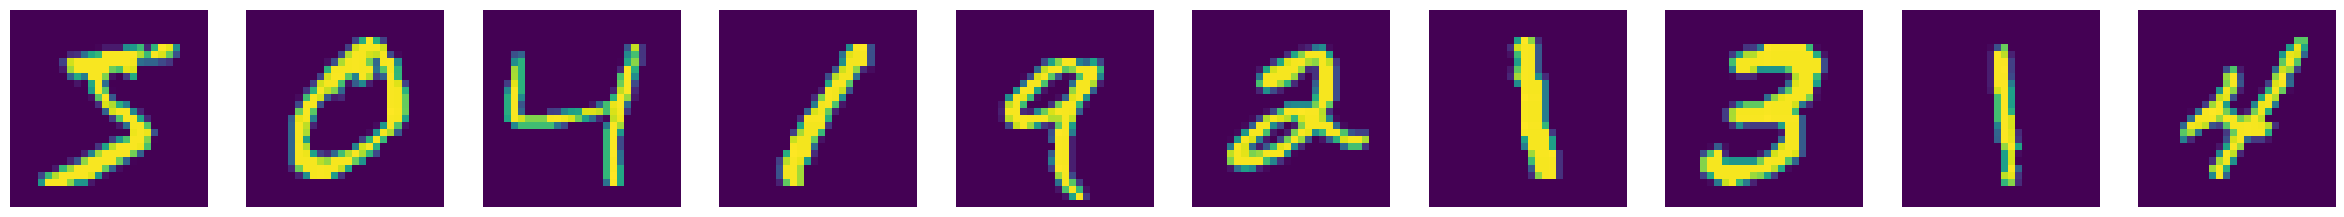

In [14]:
fig, ax = plt.subplots(1, 10, figsize=(30, 50))
for i in range(10):
    ax[i].imshow(mnist_transform(x_train[i, :, :, :]))
    ax[i].axis('off')
fig.show()

## Define Conditional GAN model class

In [9]:
z_dim = 100
num_classes = 10
img_shape = (28, 28, 1)

In [412]:
class CGAN(keras.Model):
    def __init__(self):
        super().__init__()
        self.discriminator = self._build_discriminator()
        self.generator = self._build_generator()
        
    def compile_model(self, discriminator_optimizer, generator_optimizer):
        super().compile(run_eagerly=False)
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = BinaryCrossentropy()
        self.discriminator_loss_metric = Mean(name='d_loss')
        self.generator_loss_metric = Mean(name='g_loss')
        
    def _build_generator(self):
        img = Input((z_dim,))
        labels = Input((num_classes,))
        
        z = Concatenate()([img, labels])
        
        z = Dense(7*7*128)(z)
        z = BatchNormalization()(z)
        z = LeakyReLU()(z)
        
        z = Reshape((7, 7, 128))(z)
        
        z = Conv2DTranspose(
            filters=128,
            kernel_size=3,
            strides=2,
            padding='same',
        )(z)
        z = BatchNormalization()(z)
        z = LeakyReLU(alpha=0.2)(z)
        
        z = Conv2DTranspose(
            filters=64,
            kernel_size=3,
            strides=2,
            padding='same',
        )(z)
        z = BatchNormalization()(z)
        z = LeakyReLU(alpha=0.2)(z)     
        
        z = Conv2D(
            filters=64,
            kernel_size=3,
            strides=1,
            padding='same',
        )(z)
        z = BatchNormalization()(z)
        z = LeakyReLU(alpha=0.2)(z)
        
        output = Conv2D(
            filters=img_shape[-1],
            kernel_size=3,
            strides=1,
            padding='same',
            activation='tanh',
        )(z)

        return Model(inputs=[img, labels], outputs=output, name='Generator')
    
    def _build_discriminator(self):
        img = Input(img_shape)
        labels = Input((num_classes,))
        z = Conv2D(
            filters=32,
            kernel_size=3,
            strides=2,
            padding='same',
        )(img)
        z = BatchNormalization()(z)
        z = LeakyReLU()(z)
        
        z = Conv2D(
            filters=64,
            kernel_size=3,
            strides=2,
            padding='same',
        )(z)
        z = BatchNormalization()(z)
        z = LeakyReLU()(z)
        
        z = Conv2D(
            filters=128,
            kernel_size=3,
            strides=2,
            padding='same',
        )(z)
        z = BatchNormalization()(z)
        z = LeakyReLU()(z)
        
        z = Flatten()(z)
        z = Dropout(0.2)(z)
        z = Concatenate()([z, labels])
        
        z = Dense(10)(z)
        z = LeakyReLU()(z)
        z = Dropout(0.2)(z)
        
        output = Dense(1, activation='sigmoid')(z)
        
        return Model(inputs=[img, labels], outputs=output, name='Discriminator')
    
    def train_step(self, batch_data):
        img, labels = batch_data
        batch_size = img.shape[0]
        real_target_labels = tf.ones((batch_size, 1))
        fake_target_labels = tf.zeros((batch_size, 1))
        
        # Discriminator Loss
        with tf.GradientTape() as tape:
            real_target_labels_noisy = real_target_labels - 0.05 * tf.random.uniform(tf.shape(real_target_labels))
            predictions = self.discriminator((img, labels))
            d_loss = 0.5*self.loss_fn(real_target_labels_noisy, predictions)
                
        gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discriminator_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))
        
        with tf.GradientTape() as tape:
            z = tf.random.normal((batch_size, z_dim))
            fake_img = self.generator((z, labels))
            fake_target_labels_noisy = fake_target_labels + 0.05 * tf.random.uniform(tf.shape(fake_target_labels))
            predictions = self.discriminator((fake_img, labels))
            d_loss = 0.5*self.loss_fn(fake_target_labels_noisy, predictions)
        
        gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discriminator_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))
            
        with tf.GradientTape() as tape:
            # Generator Loss
            z = tf.random.normal((batch_size, z_dim))
            fake_img = self.generator((z, labels))
            fake_predictions = self.discriminator((fake_img, labels))
            g_loss = self.loss_fn(real_target_labels, fake_predictions)
            
        gradients = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator_optimizer.apply_gradients(zip(gradients, self.generator.trainable_weights))
        
        self.discriminator_loss_metric.update_state(d_loss)
        self.generator_loss_metric.update_state(g_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    @property
    def metrics(self):
        return [self.discriminator_loss_metric, self.generator_loss_metric]

In [413]:
cgan.discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_155 (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_152 (Conv2D)            (None, 14, 14, 32)   320         ['input_155[0][0]']              
                                                                                                  
 batch_normalization_111 (Batch  (None, 14, 14, 32)  128         ['conv2d_152[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_240 (LeakyReLU)    (None, 14, 14, 32)   0           ['batch_normalization

## Define parameters

In [16]:
epochs = 50
batch_size = 64

generator_optimizer = Adam(learning_rate=2e-4)
discriminator_optimizer = Adam(learning_rate=1e-4)

## Define a Data Iterator

In [17]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
                .map(lambda x, y: (mnist_transform(x), y)) \
                .batch(batch_size, drop_remainder=True).repeat()

## Define Callback

In [416]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.z = tf.random.normal((10, 10, z_dim))
        self.labels = tf.keras.utils.to_categorical(np.arange(10), num_classes=10, dtype=np.float32)
        
    def on_train_begin(self, logs):
        self.d_losses = []
        self.g_losses = []
        
    def on_batch_end(self, batch, logs):
        self.d_losses.append(logs['d_loss'])
        self.g_losses.append(logs['g_loss'])
        
    def on_epoch_end(self, epoch, logs):
        fig, ax = plt.subplots(10, 10, figsize=(20, 20))
        for i in range(10):
            generated_digits = self.model.generator((self.z[i], self.labels), training=False)
            for j in range(10):
                ax[i][j].matshow(np.clip(generated_digits[j]*127.5 + 127.5, 0, 255).astype(int), cmap='viridis')
                ax[i][j].axis('off')
        fig.savefig(f"../data/tmp/mnist/generated_digits_{epoch:03}.png")
        plt.close()

        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(self.d_losses, label='Discriminator loss')
        ax.plot(self.g_losses, label='Generator loss')
        ax.legend()
        fig.savefig(f"../data/tmp/mnist/training_losses.png")
        plt.close()
        
    def on_train_end(self, logs):
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(self.d_losses, label='Discriminator loss')
        ax.plot(self.g_losses, label='Generator loss')
        ax.legend()
        fig.savefig(f"../data/tmp/mnist/training_losses.png")
        plt.close()

In [417]:
callback = CustomCallback()

## Train CGAN model

In [418]:
cgan = CGAN()

In [419]:
print(f"Number of params in generator: {cgan.generator.count_params()}")
print(f"Number of params in discriminator: {cgan.discriminator.count_params()}")

Number of params in generator: 981185
Number of params in discriminator: 114169


In [420]:
cgan.compile_model(discriminator_optimizer, generator_optimizer)

In [421]:
cgan.fit(train_data,
         epochs=epochs,
         callbacks=[callback],
         steps_per_epoch=1500
        )

Epoch 1/50
1500/1500 [==============================] - 24s 15ms/step - d_loss: 0.2670 - g_loss: 1.2875
Epoch 2/50
1500/1500 [==============================] - 23s 15ms/step - d_loss: 0.3179 - g_loss: 0.8615
Epoch 3/50
1500/1500 [==============================] - 23s 15ms/step - d_loss: 0.3292 - g_loss: 0.7811
Epoch 4/50
1500/1500 [==============================] - 22s 15ms/step - d_loss: 0.3175 - g_loss: 0.8243
Epoch 5/50
1500/1500 [==============================] - 23s 15ms/step - d_loss: 0.3223 - g_loss: 0.8088
Epoch 6/50
1500/1500 [==============================] - 24s 16ms/step - d_loss: 0.3243 - g_loss: 0.7999
Epoch 7/50
1500/1500 [==============================] - 39s 26ms/step - d_loss: 0.3240 - g_loss: 0.8017
Epoch 8/50
1500/1500 [==============================] - 26s 17ms/step - d_loss: 0.3265 - g_loss: 0.7951
Epoch 9/50
1500/1500 [==============================] - 26s 17ms/step - d_loss: 0.3270 - g_loss: 0.7983
Epoch 10/50
1500/1500 [==============================] - 25s 17m

In [111]:
# Generate GIF
frames = [Image.open(i) for i in Path(f"../data/tmp/mnist").rglob("generated_digits_*")]
frame_one = frames[0]
frame_one.save("../data/tmp/mnist/animation.gif", append_images=frames, format="GIF", save_all=True, duration=400)

### Generating samples from trained model

C:\Users\Chirag\AppData\Local\Temp\ipykernel_3332\3091759853.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


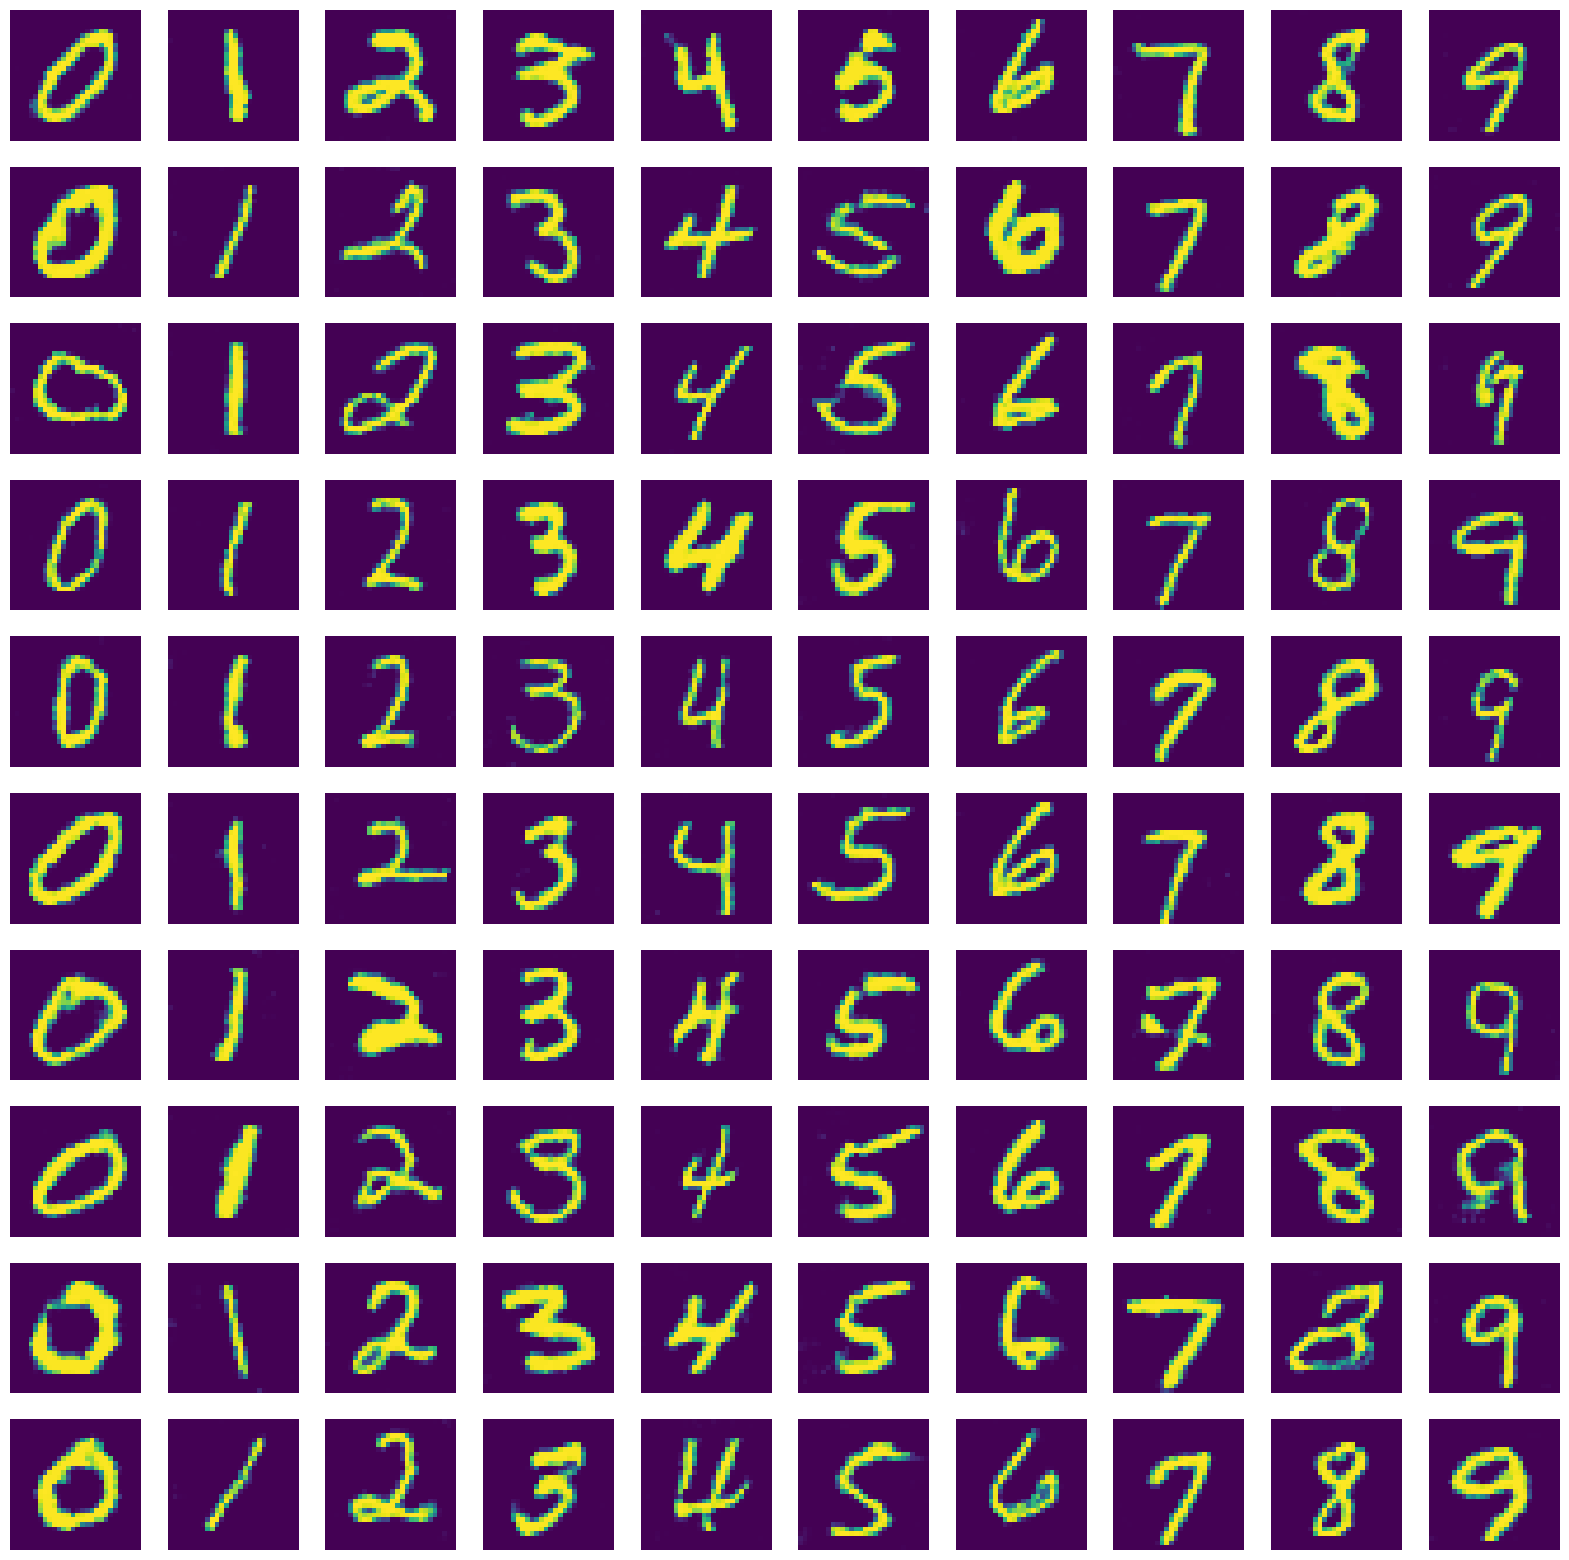

In [369]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    labels = tf.keras.utils.to_categorical(np.arange(10), num_classes=10, dtype=np.float32)
    z = tf.random.normal((10, z_dim))
    generated_digit = cgan.generator((z, labels), training=False)
    for j in range(10):
        ax[i][j].imshow(np.clip(generated_digit[j]*127.5 + 127.5, 0, 255).astype(int))
        ax[i][j].axis('off')
fig.show()

### Interpolating between two classes

In [113]:
tf.keras.utils.to_categorical(1, num_classes=10)

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [146]:
np.vstack([z]*10).shape

(10, 100)

In [206]:
class_A = 7
class_B = 6

class_A_vector = tf.keras.utils.to_categorical(class_A, num_classes=10)
class_B_vector = tf.keras.utils.to_categorical(class_B, num_classes=10)

# Intermediate conditional vectors
intermediate_labels = []
for i in np.linspace(0.0, 1.0, 10):
    intermediate_labels.append(class_A_vector*(1-i) + i*class_B_vector)
    
intermediate_labels = np.array(intermediate_labels)
z = tf.random.normal((1, z_dim))
generated_digits = cgan.generator((np.vstack([z]*10), intermediate_labels), training=False)

C:\Users\Chirag\AppData\Local\Temp\ipykernel_7524\3441963691.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


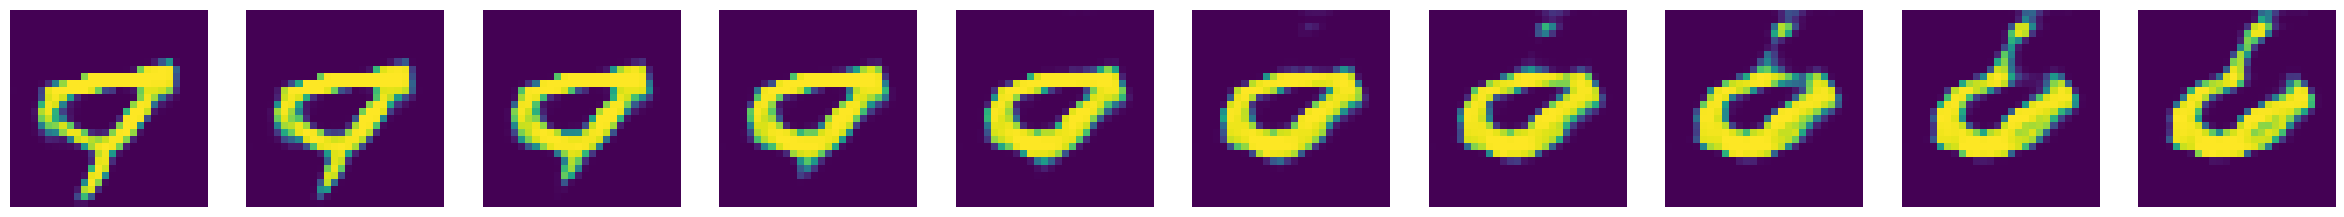

In [207]:
fig, ax = plt.subplots(1, 10, figsize=(30, 50))
for i in range(10):
    ax[i].imshow(np.clip(generated_digits[i]*127.5 + 127.5, 0, 255).astype(int), cmap='viridis')
    ax[i].axis('off')
fig.show()